In [1]:
from model import AGC_STFT_GRU
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

In [3]:
model = AGC_STFT_GRU(160, 40, 160, 80)   
package = torch.load('/home/yhjeon/projects/IITP_SE/NS_AGC/models/AGC_endtoend_r1/trained_ckpts/AGC_default.pth.tar', map_location='cpu')
model.load_state_dict(package['state_dict'])

model.cpu()
model.eval()


AGC_STFT_GRU(
  (relu): ReLU()
  (gru): GRU(81, 40, batch_first=True)
  (lin): Linear(in_features=40, out_features=1, bias=True)
  (upsample): Upsample(scale_factor=80.0, mode='nearest')
)

/home/yhjeon/anaconda3/envs/denoiser2/lib/python3.8/site-packages/torch/functional.py:650: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:863.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


1 프레임 지연시간: 10.0 ms
frame by frame inference 일치 여부: 1
0


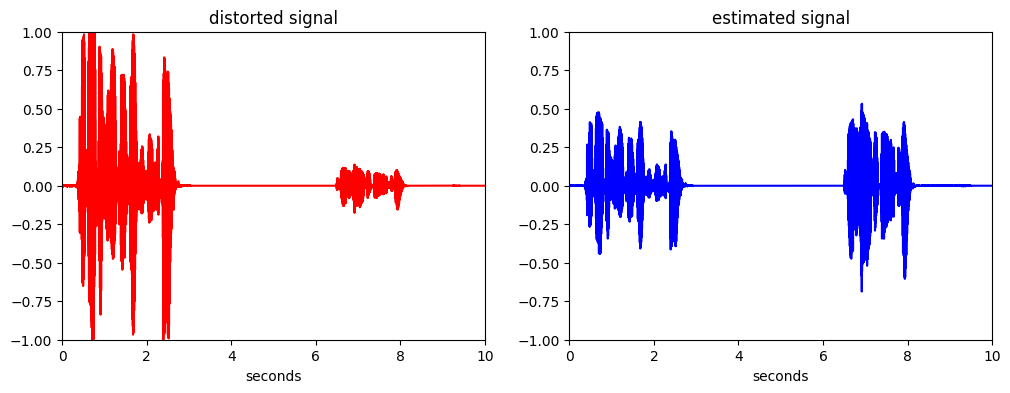

In [4]:
import time
import soundfile as sf
import numpy as np

for i in range(1):
    frame_time_max = 0

    start = time.time()

    wav = sf.read('/home/yhjeon/projects/IITP_SE/NS_AGC/models/AGC_endtoend_r1/samples/wave_distorted_{0}.wav'.format(i))[0]

    wav = torch.FloatTensor(wav)

    wav = wav.unsqueeze(0).cpu()

    est, _ = model(wav)

    hidden = None

    allclose = 1

    no_allclose = 0

    # dns-challenge 기준으로 1 프레임 지연시간 측정
    print('1 프레임 지연시간: {0:.1f} ms'.format((model.win_len / 16 - model.hop_len / 16) + model.hop_len / 16))

    for frame in range(1000):
        start = time.time()

        wav_frame = wav[...,(frame)*80:(frame + 2)*80]

        if frame != 0:
            wav_frame = torch.cat((torch.zeros((1, 80)), wav[...,(frame)*80:(frame + 2)*80]), dim=1)
        est_frame, hidden = model(wav_frame, hidden)
        end  = time.time()
        elapsed = end - start

        xaxis = np.arange(0, 10, 1/16000)
        xaxis_frame = np.arange(0, 0.005, 1/16000)

        if frame_time_max < elapsed:
            frame_time_max = elapsed

        if frame > 0:
            # 10ms win, 5ms hop 단위로 inference시 전체 inference와 같은 결과가 나오는지 확인
            if torch.allclose(est[...,(frame+1)*80:(frame+2)*80], est_frame):
                pass
            else:
                allclose = 0 # 같은 결과가 나오지 않는 frame이 있는 경우
                no_allclose += 1
        
        # if frame > 100 and frame < 104:
        #     plt.figure(figsize=[12, 4])
        #     plt.subplot(1, 2, 1)
        #     plt.axis([0, 0.005, -1, 1])
        #     plt.plot(xaxis_frame, wav_frame[0][80:].cpu(), color='red')
        #     plt.xlabel('seconds')
        #     plt.title('distorted signal(1 frame)')
        #     plt.subplot(1, 2, 2)
        #     plt.axis([0, 0.005, -1, 1])
        #     plt.plot(xaxis_frame, est_frame[0].cpu().detach(), color='blue')
        #     plt.xlabel('seconds')
        #     plt.title('estimated signal(1 frame)')
        
    print('frame by frame inference 일치 여부: {0}'.format(allclose)) #일치하는 경우 1, 아닌 경우 0 

    print(no_allclose)

    est = est[0].cpu().detach()

    wav = wav[0].cpu()

    # plot


    plt.figure(figsize=[12, 4])
    plt.subplot(1, 2, 1)
    plt.axis([0, 10, -1, 1])
    plt.plot(xaxis, wav, color='red')
    plt.xlabel('seconds')
    plt.title('distorted signal')
    plt.subplot(1, 2, 2)
    plt.axis([0, 10, -1, 1])
    plt.plot(xaxis, est, color='blue')
    plt.xlabel('seconds')
    plt.title('estimated signal')
    plt.show()



1 프레임 지연시간: 10.0 ms
frame by frame inference 일치 여부: 1


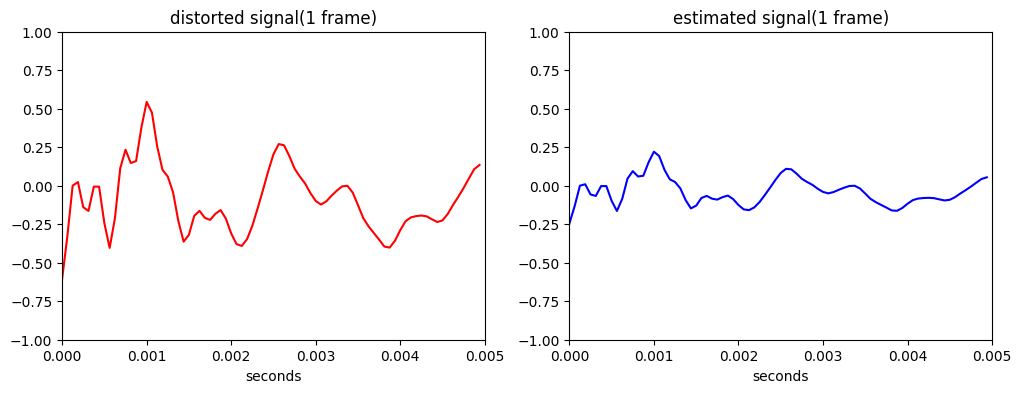

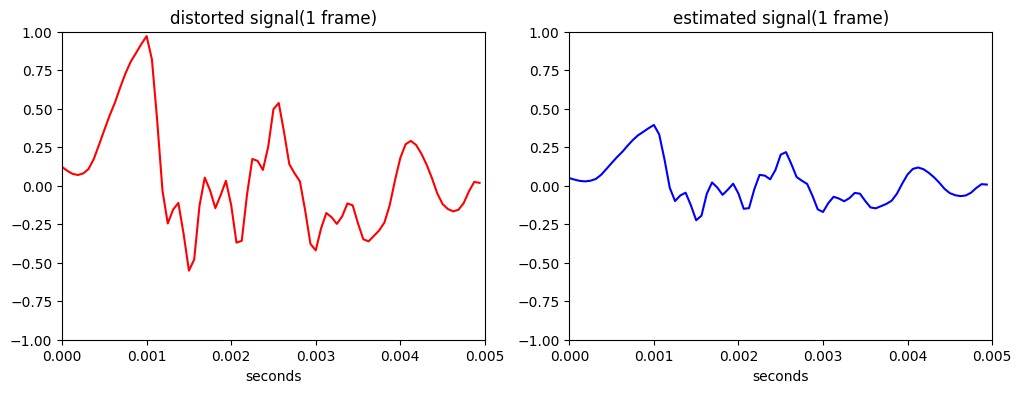

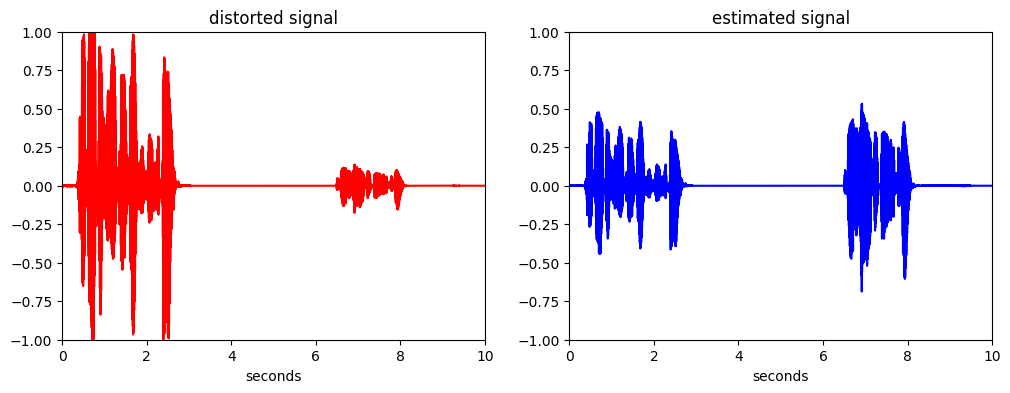

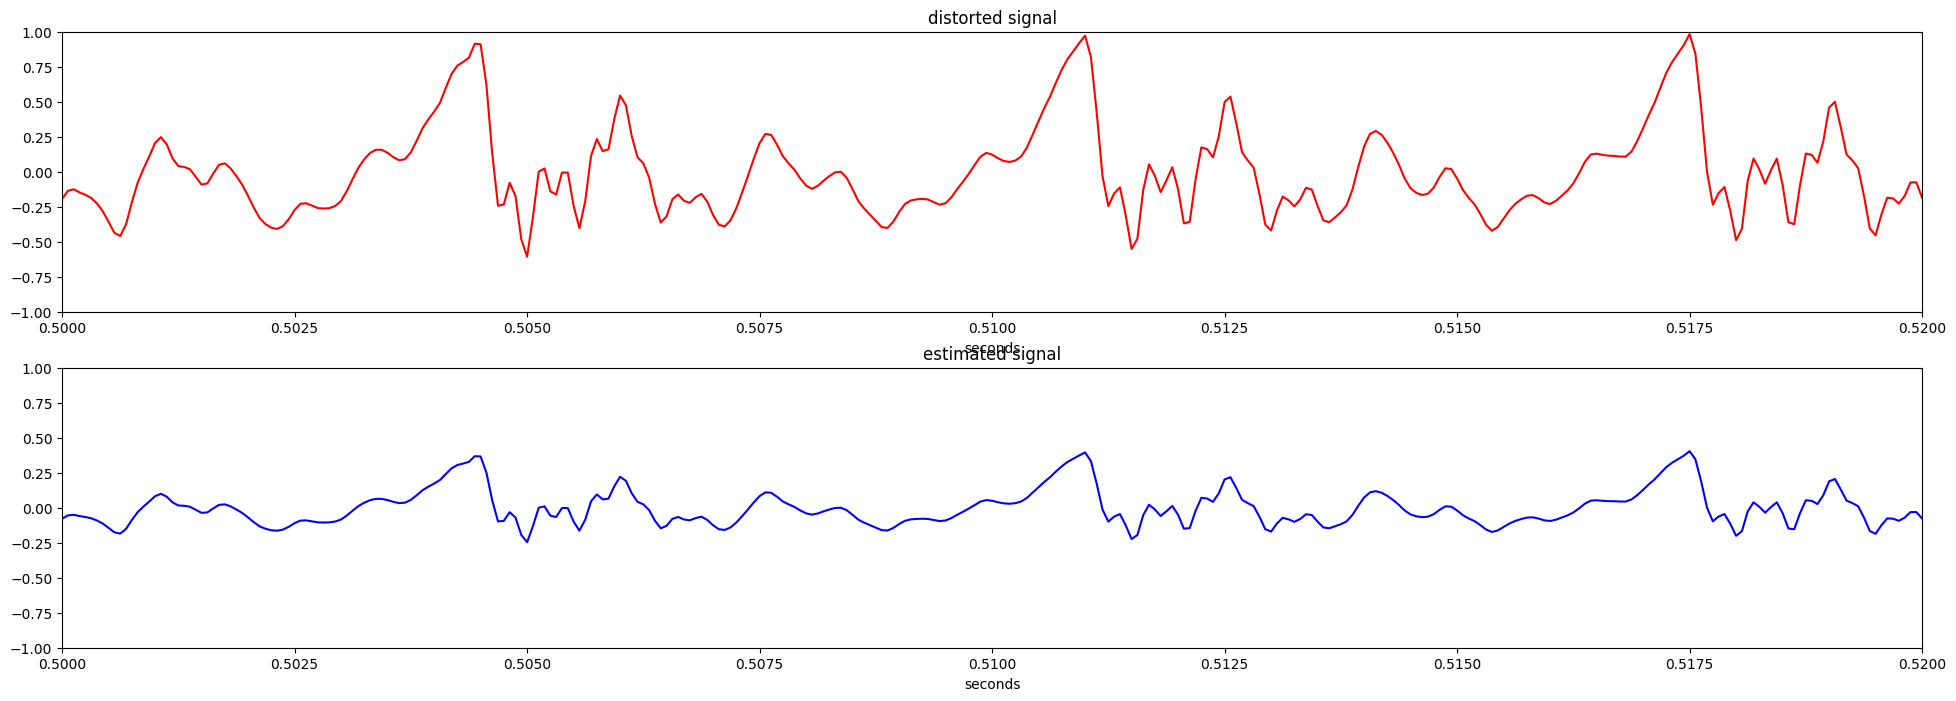

In [5]:
import time
import soundfile as sf
import numpy as np
import onnxruntime

ort_session = onnxruntime.InferenceSession("/home/yhjeon/projects/IITP_SE/NS_AGC/models/AGC_endtoend_r1/trained_onnx/AGC_default.onnx")

ort_session_frame = onnxruntime.InferenceSession("/home/yhjeon/projects/IITP_SE/NS_AGC/models/AGC_endtoend_r1/trained_onnx/AGC_frame.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

for i in range(1):
    frame_time_max = 0
    start = time.time()
    wav = sf.read('/home/yhjeon/projects/IITP_SE/NS_AGC/models/AGC_endtoend_r1/samples/wave_distorted_{0}.wav'.format(i))[0]
    wav = torch.FloatTensor(wav)
    wav = wav.unsqueeze(0).cpu()
    ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(wav)}
    est = ort_session.run(None, ort_inputs)[0]
    hidden = None
    allclose = 1

    # dns-challenge 기준으로 1 프레임 지연시간 측정
    print('1 프레임 지연시간: {0:.1f} ms'.format((model.win_len / 16 - model.hop_len / 16) + model.hop_len / 16))

    for frame in range(1000):
        start = time.time()

        # 첫 프레임은 그대로 입력하고 두 번째 프레임부터는 signal의 왼쪽에 hop_len만큼 zero padding을 해서 입력 (onnx의 STFT 연산에 오류가 없게 하기 위함)
        if frame == 0:
            wav_frame = wav[...,(frame)*80:(frame + 2)*80]
        else:
            wav_frame = torch.cat((torch.zeros((1, 80)), wav[...,(frame)*80:(frame + 2)*80]), dim=1)

        if frame == 0:
            ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(wav_frame)}
            est_frame, hidden = ort_session.run(None, ort_inputs)
        if frame > 0:
            ort_inputs = {ort_session_frame.get_inputs()[0].name: to_numpy(wav_frame), ort_session_frame.get_inputs()[1].name: hidden}
            est_frame, hidden = ort_session_frame.run(None, ort_inputs)


        end  = time.time()
        elapsed = end - start

        xaxis = np.arange(0, 10, 1/16000)
        xaxis_frame = np.arange(0, 0.005, 1/16000)

        if frame_time_max < elapsed:
            frame_time_max = elapsed

        if frame > 0:
            # 10ms win, 5ms hop 단위로 inference시 전체 inference와 같은 결과가 나오는지 확인
            if np.allclose(est[...,(frame+1)*80:(frame+2)*80], est_frame, rtol=1e-2, atol=1e-4):
                pass
            else:
                allclose = 0 # 같은 결과가 나오지 않는 frame이 있는 경우
        
        if frame >= 100 and frame <= 101:
            plt.figure(figsize=[12, 4])
            plt.subplot(1, 2, 1)
            plt.axis([0, 0.005, -1, 1])
            plt.plot(xaxis_frame, wav_frame[0][160:].cpu(), color='red')
            plt.xlabel('seconds')
            plt.title('distorted signal(1 frame)')
            plt.subplot(1, 2, 2)
            plt.axis([0, 0.005, -1, 1])
            plt.plot(xaxis_frame, est_frame[0], color='blue')
            plt.xlabel('seconds')
            plt.title('estimated signal(1 frame)')

        
    print('frame by frame inference 일치 여부: {0}'.format(allclose)) #일치하는 경우 1, 아닌 경우 0 

    est = est[0]

    wav = wav[0]

    # plot

    plt.figure(figsize=[12, 4])
    plt.subplot(1, 2, 1)
    plt.axis([0, 10, -1, 1])
    plt.plot(xaxis, wav, color='red')
    plt.xlabel('seconds')
    plt.title('distorted signal')
    plt.subplot(1, 2, 2)
    plt.axis([0, 10, -1, 1])
    plt.plot(xaxis, est, color='blue')
    plt.xlabel('seconds')
    plt.title('estimated signal')
    plt.show()
    
    xaxis_2 = np.arange(0.5, 0.52, 1/16000)
    plt.figure(figsize=[24, 8])
    plt.subplot(2, 1, 1)
    plt.axis([0.5, 0.52, -1, 1])
    plt.plot(xaxis_2, wav[8000:8321], color='red')
    plt.xlabel('seconds')
    plt.title('distorted signal')
    plt.subplot(2, 1, 2)
    plt.axis([0.5, 0.52, -1, 1])
    plt.plot(xaxis_2, est[8000:8321], color='blue')
    plt.xlabel('seconds')
    plt.title('estimated signal')
    plt.show()